In [1]:
import torch
import pandas as pd
import numpy as np
import transformers
import torchvision
from torchvision import models, transforms
from PIL import Image
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
import random
import time
import os
import re
import math
from torch.utils.tensorboard import SummaryWriter

from mult_img_data_loader import *
from multiple_imgs_model import *
from train_val import *

from utils import *

In [2]:
csv_name = "/home/muditd/FakeNewsDetection/datasets/FakeNewsNet/Final_dataset/PoltiFact_data.csv"

df = clean_data(csv_name)

## Split data 
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk].reset_index(drop=True) 
df_test = df[~msk].reset_index(drop=True)


if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


# define a callable image_transform with Compose
image_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(224, 224)),
        torchvision.transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)
# Specify `MAX_LEN`
MAX_LEN = 500

/home/muditd/.conda/envs/fn/lib/python3.6/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/muditd/.conda/envs/fn/lib/python3.6/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


There are 1 GPU(s) available.
Device name: GeForce GTX 1080 Ti


In [3]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

transformed_dataset_train = FakeNewsDataset(df_train, image_transform, tokenizer, MAX_LEN)
train_dataloader = DataLoader(transformed_dataset_train, batch_size=4,
                        shuffle=True, num_workers=0)

transformed_dataset_val = FakeNewsDataset(df_test, image_transform, tokenizer, MAX_LEN)
val_dataloader = DataLoader(transformed_dataset_val, batch_size=4,
                        shuffle=True, num_workers=0)

In [4]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss() ## Fake news detects loss (Sub task 1)

pdist = nn.PairwiseDistance(p=2)
hinge_loss = nn.HingeEmbeddingLoss(reduction='none')

def sim_loss(x, y, pdist, hinge_loss):

    centroid = torch.mean(x, dim=1, keepdim=True)

    centroid = centroid.repeat(1, x.size(1), 1)

    y = y.unsqueeze(1).repeat(1, x.size(1))

    batch_size = x.shape[0]

    # Squash samples and timesteps into a single axis
    x_reshape = x.contiguous().view(-1, x.size(-1))  # (b_s * num_components, latent_dim)

    centroid_reshape = centroid.contiguous().view(-1, centroid.size(-1))  # (b_s * num_components, latent_dim)


    dist_mat = pdist(x_reshape, centroid_reshape).view(batch_size, -1)
    
    total_loss = torch.mean(hinge_loss(dist_mat, y), dim=1)
    
    # total_loss = torch.mean(torch.mean(hinge_loss(dist_mat, y), dim=1))

    # dist_mat = torch.cdist(latent_tensors, latent_tensors, p=p)
    # idx = torch.nonzero(torch.triu(dist_mat) , as_tuple=True) 
    # clust_dists = dist_mat[idx[0], idx[1], idx[2]].view(batch_size, -1)
    # clust_loss = torch.var(clust_dists, -1, keepdim=True)
    # total_loss = torch.mean(clust_loss)

    return total_loss 



def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [5]:
parameter_dict_model={
                'single_enc_img_dim': 4096,
                'single_img_fc1_out': 1024,
                'single_img_latent_dim': 256,
                'hidden_size': 256,
                'num_layers': 1,
                'multiple_enc_img_dim': 128,
                'bidirectional': True,
                'text_fc1_out': 512,
                'latent_text': 128,
                'fine_tune_vgg': True,
                'freeze_bert': True,
                'multimodal_latent_dim': 128,
                'nb_classes': 2,
                'latent_fused': 128,
                'dropout_p': 0.30,
                'num_classes': 2
                }

set_seed(42)  

In [6]:
final_model = Multiple_Images_Model(parameter_dict_model)
final_model = final_model.to(device)

In [30]:
loaded_variables = torch.load("./saved_models/best_model_margin_1_normalize_1.pt",  map_location=device)
final_model.load_state_dict(loaded_variables['model_state_dict'])

<All keys matched successfully>

In [31]:
!nvidia-smi

Thu Dec 31 12:55:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   43C    P2    65W / 250W |   7393MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [32]:
cols = ['col_'+str(i) for i in range(1,parameter_dict_model['multimodal_latent_dim']+1)]
cols += ['sample_no']
cols += ['label']
df_space = pd.DataFrame(columns=cols)
df_mean = pd.DataFrame(columns=cols)

In [33]:
import seaborn as sns

In [34]:
i = 0
k = 0
for batch in val_dataloader:
    img_ip , text_ip, label = batch["image"], batch["BERT_ip"], batch['label']

    b_input_ids, b_attn_mask = tuple(t.to(device) for t in text_ip)

    imgs_ip = img_ip.to(device)

    b_labels = label.to(device)

    # Compute logits
    with torch.no_grad():
        logits, latent_vectors = final_model(text=[b_input_ids, b_attn_mask], image=imgs_ip, label=b_labels)
    
    # Compute loss
    loss_sim = sim_loss(latent_vectors, b_labels, pdist, hinge_loss)
    
    latent_vectors = latent_vectors.cpu().numpy()
    print(latent_vectors.shape)
    for idx_i in range(latent_vectors.shape[0]):
        curr_element = np.mean(latent_vectors[idx_i, :, :], axis=0).tolist()
#         print(curr_element, len(curr_element))
        curr_element.extend([loss_sim[idx_i].item(), label[idx_i].item()])
#         print(curr_element, len(curr_element))
        df_mean.loc[i] = curr_element
        for idx_j in range(latent_vectors.shape[1]):
            curr_element = latent_vectors[idx_i, idx_j, :].tolist()
            curr_element.extend([i, label[idx_i]])
            df_space.loc[k] = curr_element
            k += 1
        i += 1
#     break

(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)


/home/muditd/.conda/envs/fn/lib/python3.6/site-packages/PIL/Image.py:952: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(4, 3, 128)
(3, 3, 128)


In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [36]:
def plot_space(data_subset, Y_hue):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(data_subset)
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x=tsne_results[:,0], y=tsne_results[:,1],
        hue=Y_hue,
#         palette=sns.color_palette("hls"),
#         legend="full",
        alpha=0.3
    )

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 333 samples in 0.003s...
[t-SNE] Computed neighbors for 333 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 333 / 333
[t-SNE] Mean sigma: 0.437010
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.220306
[t-SNE] KL divergence after 300 iterations: 1.139223


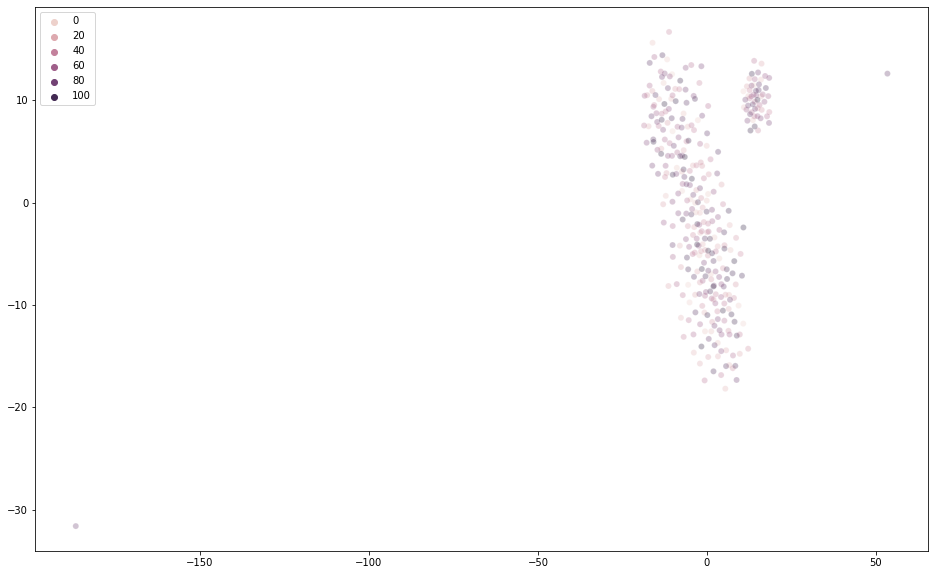

In [37]:
X = df_space[['col_'+str(i) for i in range(1,parameter_dict_model['multimodal_latent_dim']+1)]].to_numpy()
Y_hue = df_space['sample_no'].to_numpy()
plot_space(X, Y_hue)

In [38]:
df_mean

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,...,col_121,col_122,col_123,col_124,col_125,col_126,col_127,col_128,sample_no,label
0,0.574952,0.506455,-0.461372,0.568728,0.509166,-0.445941,-0.574211,-0.573371,0.574479,0.568242,...,-0.539038,0.566433,-0.573027,-0.567944,-0.546513,0.560657,0.512384,-0.564921,2.431788,1.0
1,0.570785,0.568276,-0.569141,0.568097,0.570080,-0.570585,-0.570750,-0.515423,0.576958,0.576300,...,-0.575135,0.562134,-0.576877,-0.577260,-0.577244,0.575749,0.552183,-0.575341,1.166317,0.0
2,0.566232,0.575556,-0.574883,0.565493,0.575519,-0.577183,-0.554131,-0.570986,0.577171,0.576178,...,-0.567694,0.556591,-0.559484,-0.572357,-0.575961,0.569467,0.575645,-0.540899,1.136240,0.0
3,0.577290,0.500178,-0.480640,0.558448,0.500444,-0.490106,-0.533562,-0.558369,0.569083,0.539997,...,-0.534865,0.567312,-0.573792,-0.560739,-0.520322,0.570580,0.434740,-0.559281,2.606812,1.0
4,0.565911,0.563793,-0.573642,0.576118,0.573804,-0.577102,-0.559127,-0.573588,0.574904,0.569926,...,-0.574475,0.562590,-0.563945,-0.558951,-0.569011,0.570517,0.529187,-0.575506,1.058979,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.512703,0.483589,-0.465403,0.568830,0.509164,-0.429424,-0.574905,-0.573912,0.561491,0.548107,...,-0.542084,0.576106,-0.563153,-0.516139,-0.501722,0.574260,0.529657,-0.566461,2.531431,1.0
107,0.564668,0.574461,-0.571391,0.572751,0.572594,-0.575592,-0.575309,-0.572758,0.570654,0.565787,...,-0.577311,0.577166,-0.574794,-0.572574,-0.572300,0.573936,0.576394,-0.575522,1.000000,0.0
108,0.545830,0.575096,-0.573017,0.576749,0.577258,-0.576832,-0.577106,-0.570979,0.568698,0.577214,...,-0.570086,0.574937,-0.575828,-0.575032,-0.577202,0.565929,0.544733,-0.576890,1.191485,0.0
109,0.566480,0.548812,-0.574746,0.570450,0.561861,-0.570152,-0.575353,-0.575458,0.564203,0.570321,...,-0.571376,0.576043,-0.568815,-0.576907,-0.560199,0.577349,0.577269,-0.577012,1.162978,0.0


In [39]:
import plotly.express as px

In [40]:
def plot_bubbles(data_subset, clust_size, Y_hue):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(data_subset)
    fig = px.scatter(x=tsne_results[:,0], y=tsne_results[:,1],
                     size=clust_size, color=Y_hue)
    fig.show()

In [41]:
X = df_mean[['col_'+str(i) for i in range(1,parameter_dict_model['multimodal_latent_dim']+1)]].to_numpy()
Y_hue = df_mean['label'].to_numpy()
clust_size = df_mean['sample_no'].to_numpy()
plot_bubbles(X, clust_size, Y_hue)

[t-SNE] Computing 110 nearest neighbors...
[t-SNE] Indexed 111 samples in 0.000s...
[t-SNE] Computed neighbors for 111 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 111 / 111
[t-SNE] Mean sigma: 0.078871
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.417843
[t-SNE] KL divergence after 300 iterations: 0.360452


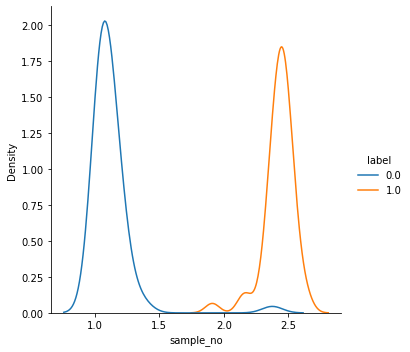

In [42]:
sns.displot(data=df_mean, x="sample_no", hue="label", kind="kde")